In [ ]:
!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -o NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
  font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

In [ ]:

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec#分割子图 
import numpy as np
#################
import tejapi
# import time 
############ 接資料
from mplfinance.original_flavor import candlestick_ohlc
from matplotlib.dates import date2num ,num2date
import matplotlib.ticker as ticker
import matplotlib.dates 


In [ ]:
tejapi.ApiConfig.api_key=""###yourkey
tejapi.ApiConfig.info()
tejapi.ApiConfig.ignoretz = True

In [ ]:
data=tejapi.get('TWN/EWNPRCSTD' ,chinese_column_name=True )
select=data["上市別"].unique()
select=select[1:3]
condition =(data["上市別"].isin(select)) & ( data["證券種類名稱"]=="普通股" )
data=data[condition]
twid=data["證券碼"].to_list()

In [ ]:
twid


In [ ]:

opts={'columns': ['coid','open_d','close_d','high_d','low_d' ,'mdate', 'volume', 'close_adj']}
start='2022-1-01'
end="2022-03-07"
tw=tejapi.get('TWN/EWPRCD',coid=twid,
                mdate={'gt':start,'lt':end},
                paginate=True,
                chinese_column_name=True,
                opts=opts
                )

In [ ]:
a=tw
a=tw.groupby(by=["證券碼"])
b=list(a)

In [ ]:
b


In [ ]:
def selectstock(b,number,minnum,num) : # b為用groupby做出來的list
    output=[]
    for i in range(len(b)):
        a=b[i][1]
    # a=a[0# a["證券碼"]=twid[i]
        a["五日均量"]=a["成交量(千股)"].rolling(5).sum()
        a["五日均價"]=a["收盤價-除權息"].rolling(5).mean()
        
        a["前幾日平均"]=(a["五日均量"]-a["成交量(千股)"]) / 4
        a["成交量"+str(number)+"倍喔"]=a["成交量(千股)"]-a['前幾日平均'] *number 
        a.drop('五日均量',axis=1)
        if a["成交量(千股)"].mean() > minnum  :
            output.append(a)
    stockineed=[]    

    for j in output:
        j.reset_index(drop=True,inplace=True)
        if j["成交量"+str(number)+"倍喔"][len(j)-1] > 0 :
            
            if j["收盤價-除權息"][len(j)-1] > j["收盤價-除權息"][len(j)-2]*num :
                stock=j["證券碼"][0]
                stockineed.append(stock)
    return stockineed

In [ ]:
stockineed=selectstock(b,5,500,1.03)    


In [ ]:

condition=tw["證券碼"].isin(stockineed)
tw1=tw[condition]
a=tw1.groupby("證券碼")
a=list(a)  
for i in a:
    i[1].set_index("日期",inplace=True)

In [ ]:
opts={'columns': ['coid','stk_name','mkt','tejindnm',]}
data1=tejapi.get('TWN/ANPRCSTD' ,
                opts=opts,
                chinese_column_name=True,

                paginate=True,
                coid=stockineed)

In [ ]:

def getplot(finaldata):

    for i in range(len(finaldata)):
        
        out=finaldata[i][1]
        name=data1[data1["證券碼"]==finaldata[i][0]]        
        outputname0=name.loc[i,'證券名稱']
        outputname1=name.loc[i,'上市別']
        outputname2=name.loc[i,"TEJ產業名"]
        # out.reset_index(drop=True,inplace=True)
        if outputname1 == "TSE":
            outputname1 ="上市"
        else :
            outputname1= "上櫃"
        fig = plt.figure(figsize=(6,6))
        grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)
        ax1=plt.subplot(grid[:2, :])
        ax2=plt.subplot(grid[2, :])
       
        date= [i for i in range(len(out))]
       
        out_index= [tuple([date[i],out.開盤價[i],out.最高價[i],out.最低價[i],out.收盤價[i]]) for i  in range(len(out))]
        candlestick_ohlc(ax1, out_index, width=0.6, colorup='r', colordown='g', alpha=0.75)

      
        
        ax1.set_xticks(range(0, len(out.index), 10))
        ax1.set_xticklabels(out.index[::10])
       
        ax1.set_title([str(out["證券碼"][0]),outputname0,outputname1,outputname2])
        ax1.set_ylabel('Price')
        ax1.grid(linestyle="--",alpha=0.8)
       
        red_pred = np.where(out["收盤價"] >= out["開盤價"],out["成交量(千股)"], 0)
        blue_pred = np.where(out["收盤價"] <  out["開盤價"], out["成交量(千股)"], 0)
        out1=out.reset_index(drop=True )
        ax2.bar(out1.index,red_pred, facecolor="red")
        ax2.bar(out1.index,blue_pred,facecolor="green")
        ax2.set_xticks(range(0, len(out.index), 5))
        ax2.set_xticklabels(out.index[::5])
        ax2.set_ylabel('vol')

        plt.legend(loc='best')
        fig.autofmt_xdate()
        fig.tight_layout()
        plt.show()
        
 #        


No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


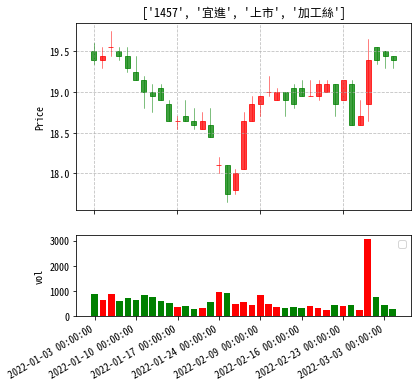

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


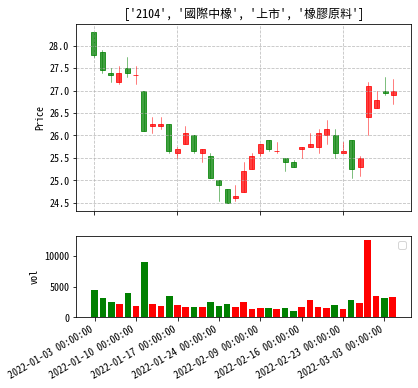

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


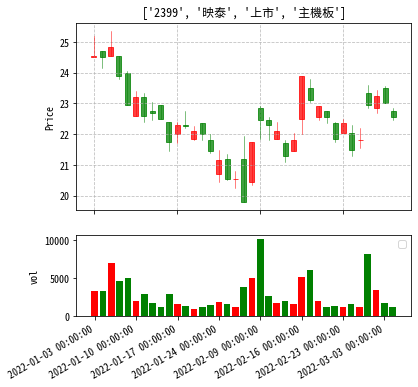

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


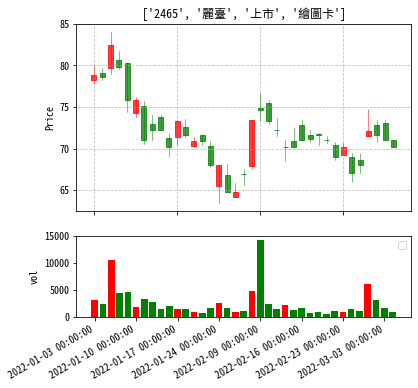

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


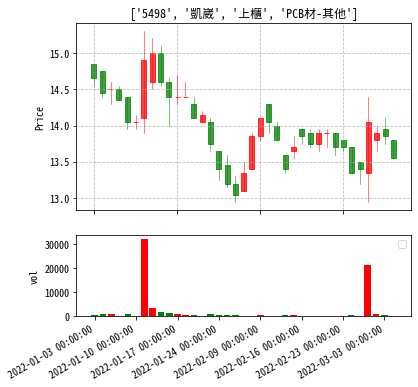

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


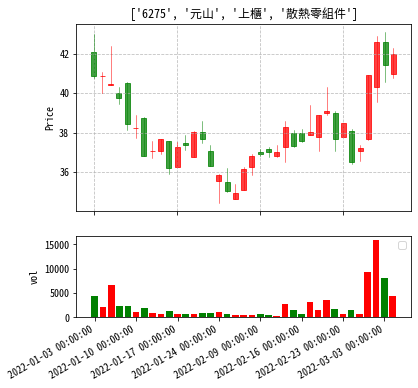

No handles with labels found to put in legend.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


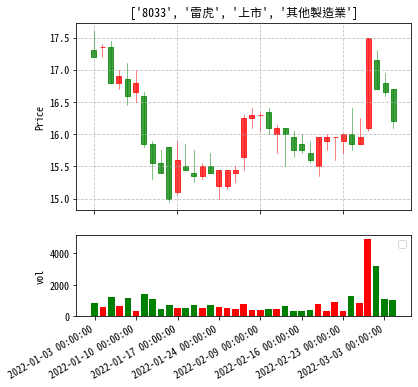

In [ ]:
getplot(a)